# Notebook for testing task for Boston Gene

### Рак поджелудочной железы

### Code

In [89]:
# Imports
# adding project folder to lib search path

import pandas as pd
import numpy as np
import os
import sys
import itertools as it
from scipy import stats

# adding project scripts to lib search path
project = "/".join((os.path.split(os.getcwd())[0], os.path.split(os.getcwd())[1], 'scripts'))
if project not in sys.path:
    sys.path.append(project)
    
# adding ComBat folder to lib search path
combat = "/".join((os.path.split(os.getcwd())[0], os.path.split(os.getcwd())[1], 'ComBat'))
if combat not in sys.path:
    sys.path.append(combat)


# here we will import ComBat from https://github.com/brentp/combat.py
# which will help us dealing with batch-effect
import combat

#### Databases

In [2]:
# creating expression dataframe
exp_data = pd.read_csv('data/expression_table_normalised_icgc.txt', sep="\t")
exp_data.rename(columns={exp_data.columns[0]: 'gene_id'}, inplace=True)
exp_data.head()

,gene_id,ICGC_0006,ICGC_0007,ICGC_0009,ICGC_0075,ICGC_0354,ICGC_0020,ICGC_0021,ICGC_0025,ICGC_0026,...,ICGC_0535,ICGC_0536,ICGC_0502,ICGC_0503,ICGC_0518,ICGC_0507,ICGC_0521,ICGC_0522,ICGC_0526,ICGC_0543
0,ENSG00000000003,4.935214,5.114459,5.375416,4.272855,3.585551,4.728254,5.411612,5.620586,4.817511,...,3.332555,4.157640,4.483416,4.951604,3.836224,3.972830,5.382327,4.308381,4.732541,5.140055
1,ENSG00000000419,4.034635,4.599332,4.587680,3.472525,4.173737,4.401976,4.386663,4.806422,4.443624,...,4.601348,4.409019,3.740030,4.300386,4.783368,3.927274,4.001015,3.272052,4.162536,5.284458
2,ENSG00000000457,3.925488,3.907000,3.638524,4.197544,3.757676,4.111593,3.495744,3.551271,3.676183,...,3.672093,3.511688,4.069200,3.900946,3.947078,3.994728,4.569100,4.477992,4.283187,3.101123
3,ENSG00000000460,2.483618,2.660843,3.214169,2.842177,3.559219,2.621409,3.198682,4.087306,2.686024,...,2.918784,2.919825,2.932658,2.092648,3.056026,2.653496,3.048836,3.573936,2.998799,3.477693
4,ENSG00000000938,2.484806,1.750494,2.794076,2.353310,1.440256,3.264178,3.445729,3.103411,2.527272,...,3.614184,2.795686,1.654626,1.726623,2.372235,1.157676,1.311957,3.346237,2.786160,2.123467


In [3]:
# gene names and ids table which was given
name_id_table = pd.read_csv('data/ensembl_table', sep="\t")
name_id_table.head()

,#id,gene,chrom,chromStart,chromEnd,strand
0,ENSG00000111671,SPSB2,chr12,6980098,6998522,-
1,ENSG00000110514,MADD,chr11,47290711,47351582,+
2,ENSG00000086015,MAST2,chr1,46252658,46501796,+
3,ENSG00000255071,SAA2-SAA4,chr11,18252969,18270182,-
4,ENSG00000169740,ZNF32,chr10,44139306,44144304,-


In [4]:
# gene names and ids table from ensembl martview
name_id_table_mart = pd.read_csv('data/mart_export_gene_name.txt')

rename_dict = dict(zip(list(name_id_table_mart.columns.values), ['gene_id', 'gene_id_v', 'gene_name']))
name_id_table_mart.rename(columns = rename_dict, inplace=True)
name_id_table_mart.head()

,gene_id,gene_id_v,gene_name
0,ENSG00000210049,ENSG00000210049.1,MT-TF
1,ENSG00000211459,ENSG00000211459.2,MT-RNR1
2,ENSG00000210077,ENSG00000210077.1,MT-TV
3,ENSG00000210082,ENSG00000210082.2,MT-RNR2
4,ENSG00000209082,ENSG00000209082.1,MT-TL1


In [5]:
# for-loop to find out gene names for given ids
# note: this loop is here, because for some genes there are no names,
# so we will call such genes as 'broken_gene'
gene_names = []
broken_genes = []

for gene_id in exp_data.gene_id:
    try:
        gene_names.append(name_id_table.loc[name_id_table['#id'] == gene_id].gene.values[0])
    except:
        gene_names.append('broken_gene')
        broken_genes.append(gene_id)

In [6]:
# final database

exp_data.insert(1, 'gene_name', gene_names)
exp_data.head()

,gene_id,gene_name,ICGC_0006,ICGC_0007,ICGC_0009,ICGC_0075,ICGC_0354,ICGC_0020,ICGC_0021,ICGC_0025,...,ICGC_0535,ICGC_0536,ICGC_0502,ICGC_0503,ICGC_0518,ICGC_0507,ICGC_0521,ICGC_0522,ICGC_0526,ICGC_0543
0,ENSG00000000003,TSPAN6,4.935214,5.114459,5.375416,4.272855,3.585551,4.728254,5.411612,5.620586,...,3.332555,4.157640,4.483416,4.951604,3.836224,3.972830,5.382327,4.308381,4.732541,5.140055
1,ENSG00000000419,DPM1,4.034635,4.599332,4.587680,3.472525,4.173737,4.401976,4.386663,4.806422,...,4.601348,4.409019,3.740030,4.300386,4.783368,3.927274,4.001015,3.272052,4.162536,5.284458
2,ENSG00000000457,SCYL3,3.925488,3.907000,3.638524,4.197544,3.757676,4.111593,3.495744,3.551271,...,3.672093,3.511688,4.069200,3.900946,3.947078,3.994728,4.569100,4.477992,4.283187,3.101123
3,ENSG00000000460,C1orf112,2.483618,2.660843,3.214169,2.842177,3.559219,2.621409,3.198682,4.087306,...,2.918784,2.919825,2.932658,2.092648,3.056026,2.653496,3.048836,3.573936,2.998799,3.477693
4,ENSG00000000938,FGR,2.484806,1.750494,2.794076,2.353310,1.440256,3.264178,3.445729,3.103411,...,3.614184,2.795686,1.654626,1.726623,2.372235,1.157676,1.311957,3.346237,2.786160,2.123467


* Note: не для всех геннов есть название по ID в таблице из задания и в таблице biomart ENSEMBL, поэтому дадим таким геннам название "broken_gene"

In [7]:
exp_data.loc[exp_data['gene_name'] == 'broken_gene'].head()

# del exp_data

,gene_id,gene_name,ICGC_0006,ICGC_0007,ICGC_0009,ICGC_0075,ICGC_0354,ICGC_0020,ICGC_0021,ICGC_0025,...,ICGC_0535,ICGC_0536,ICGC_0502,ICGC_0503,ICGC_0518,ICGC_0507,ICGC_0521,ICGC_0522,ICGC_0526,ICGC_0543
3714,ENSG00000112664,broken_gene,4.693546,4.038044,4.886379,3.753149,3.627779,4.546919,4.820432,4.285000,...,4.081546,4.246030,4.095481,4.215462,4.206276,4.175211,4.144277,3.848215,4.014745,4.742386
4540,ENSG00000120087,broken_gene,1.789388,1.744969,1.906567,1.822449,3.391405,1.722849,3.202831,3.535347,...,0.978817,1.712759,3.738991,2.620164,-0.522862,2.651291,4.146965,1.947153,3.099085,1.800168
4650,ENSG00000121083,broken_gene,5.136512,4.899977,4.645980,5.167521,5.035973,4.657140,4.437639,5.560182,...,5.364553,5.319549,4.929855,5.571250,5.048485,5.435113,5.852175,3.989615,5.742923,5.673917
5310,ENSG00000127688,broken_gene,3.119708,4.484744,4.335902,3.951604,5.315805,4.336052,4.669890,4.280446,...,4.287040,4.026894,5.001484,4.135829,4.943669,4.565042,5.660356,5.357861,3.460913,4.728115
6987,ENSG00000139617,broken_gene,-1.352647,-2.941959,-3.484852,-6.456231,1.650074,0.016062,-2.407230,0.167268,...,-0.524575,0.120612,0.045192,-0.192103,-0.858430,0.899779,1.149841,0.066097,-2.473422,-1.458277


##### Duplicates

In [8]:
# search duplicates
ser = exp_data.duplicated(exp_data.columns[2:])
id_ = ser.loc[ser == True].index

exp_data.iloc[id_]

,gene_id,gene_name,ICGC_0006,ICGC_0007,ICGC_0009,ICGC_0075,ICGC_0354,ICGC_0020,ICGC_0021,ICGC_0025,...,ICGC_0535,ICGC_0536,ICGC_0502,ICGC_0503,ICGC_0518,ICGC_0507,ICGC_0521,ICGC_0522,ICGC_0526,ICGC_0543
14318,ENSG00000198444,F8A2,-1.490681,-0.344479,-4.639051,-1.804984,0.711816,-4.070322,2.128123,1.445688,...,-5.665105,-0.825468,0.523482,0.523384,2.159762,0.857449,-7.624289,-1.149402,-7.624289,-0.709641
14554,ENSG00000201750,broken_gene,-6.846660,3.559143,5.322229,4.896339,7.204235,2.973007,5.488648,8.108064,...,4.921146,2.417626,0.512245,-7.248099,8.229997,1.069609,-6.972352,6.503999,-6.972352,7.750426
14628,ENSG00000203852,HIST2H3A,3.427891,6.047820,4.695657,4.438130,5.155921,3.888386,5.054553,4.844047,...,4.676110,4.094918,4.485994,3.879870,4.358941,3.267949,3.822498,4.370502,5.262825,5.972849
14966,ENSG00000206596,RNU1-27P,10.347322,8.935919,8.435512,9.825651,8.975713,8.171357,8.075443,7.566308,...,8.177392,8.113632,8.858730,8.459618,8.240526,8.240223,8.099164,8.972586,7.557828,7.991999
14971,ENSG00000206652,RNU1-1,10.347322,8.935919,8.435512,9.825651,8.975713,8.171357,8.075443,7.566308,...,8.177392,8.113632,8.858730,8.459618,8.240526,8.240223,8.099164,8.972586,7.557828,7.991999
14972,ENSG00000206694,RNVU1-3,-1.562834,-3.770454,-6.576803,-2.890290,-1.675458,-0.714297,-3.468882,-3.666115,...,-5.764470,-6.579539,-1.886372,-2.117019,-6.657033,-2.408525,-6.657033,-1.788893,-6.657033,-6.336460
14973,ENSG00000206737,RNVU1-18,10.347322,8.935919,8.435512,9.825651,8.975713,8.171357,8.075443,7.566308,...,8.177392,8.113632,8.858730,8.459618,8.240526,8.240223,8.099164,8.972586,7.557828,7.991999
14980,ENSG00000207005,RNU1-2,10.347322,8.935919,8.435512,9.825651,8.975713,8.171357,8.075443,7.566308,...,8.177392,8.113632,8.858730,8.459618,8.240526,8.240223,8.099164,8.972586,7.557828,7.991999
14994,ENSG00000207389,RNU1-4,10.347322,8.935919,8.435512,9.825651,8.975713,8.171357,8.075443,7.566308,...,8.177392,8.113632,8.858730,8.459618,8.240526,8.240223,8.099164,8.972586,7.557828,7.991999
14997,ENSG00000207418,RNVU1-7,8.599380,8.172068,6.679090,8.405193,7.810230,7.456809,7.268529,6.712191,...,6.594431,7.842568,6.855319,6.250133,5.766592,5.331663,7.493941,7.412852,4.904799,6.439138


#### Final table

In [9]:
# taking part from exp_data where won't be 'broken_gene'
# we can take only take "not broke" genes
###expression_dataframe = exp_data.loc[exp_data['gene_name'] != 'broken_gene']
# or all of them
# also we will delete duplicates
expression_dataframe = exp_data.drop(axis=0, index=id_)

print(exp_data.shape)
print(expression_dataframe.shape)

(18278, 98)
(18262, 98)


#### Annotation

In [10]:
# loading annotation (sample - cancer subtype) table for our task
annotation_table = pd.read_csv('data/annotation_table.txt', sep="\t", names = ['icgc_id', 'subtype'], header=0)

annotation_table.head()

,icgc_id,subtype
0,ICGC_0543,Squamous
1,ICGC_0522,Squamous
2,ICGC_0521,Squamous
3,ICGC_0535,Squamous
4,ICGC_0313,Squamous


In [11]:
# printing counts for each cancer subtype
subtype_lst = set(list(annotation_table.subtype))

print('[Subtype]: [number of samples]')

for subtype in subtype_lst:
    num_samples = len(annotation_table.loc[annotation_table['subtype'] == subtype].values)
    print(f'{subtype}: {num_samples}')

[Subtype]: [number of samples]
Pancreatic Progenitor: 30
Immunogenic: 25
ADEX: 16
Squamous: 25


#### Batch-effect

In [12]:
# taking samples data
samples_data = list(expression_dataframe.columns)[2:]

# finding out cancer subtype for each sample
samples_subtype = [annotation_table.loc[annotation_table.icgc_id == sample].subtype.values[0] for sample in samples_data]

# helpful dict to create Y for our classification
subtype_sample = {'ADEX':1, 'Immunogenic':2, 'Squamous':3, 'Pancreatic Progenitor':4}

# creating batch list with class numbers to create batches for ComBat
subtype_data = [subtype_sample[sample] for sample in samples_subtype]

In [13]:
# taking naked our dataframe to use combat on it
df_before_combat = expression_dataframe.drop(columns=['gene_name', 'gene_id'])

# some magic for columns names -_-
df_before_combat.columns = [i for i in range(96)]

In [14]:
# using ComBat
df_after_combat = combat.combat(df_before_combat, subtype_data)

# deleting
del df_before_combat

found 4 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data


* Так как по самим таблицам сложно сказать, есть ли в наших данных batch-effect, то мы проверим это с помощью PCA. Построим два графика для 2-компонент PCA: сырые данные и исправленные ComBat

### PCA

#### PCA without considering batch-effect

In [15]:
import sklearn.decomposition
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('axes',edgecolor='w')

In [16]:
expression_dataframe.head()

,gene_id,gene_name,ICGC_0006,ICGC_0007,ICGC_0009,ICGC_0075,ICGC_0354,ICGC_0020,ICGC_0021,ICGC_0025,...,ICGC_0535,ICGC_0536,ICGC_0502,ICGC_0503,ICGC_0518,ICGC_0507,ICGC_0521,ICGC_0522,ICGC_0526,ICGC_0543
0,ENSG00000000003,TSPAN6,4.935214,5.114459,5.375416,4.272855,3.585551,4.728254,5.411612,5.620586,...,3.332555,4.157640,4.483416,4.951604,3.836224,3.972830,5.382327,4.308381,4.732541,5.140055
1,ENSG00000000419,DPM1,4.034635,4.599332,4.587680,3.472525,4.173737,4.401976,4.386663,4.806422,...,4.601348,4.409019,3.740030,4.300386,4.783368,3.927274,4.001015,3.272052,4.162536,5.284458
2,ENSG00000000457,SCYL3,3.925488,3.907000,3.638524,4.197544,3.757676,4.111593,3.495744,3.551271,...,3.672093,3.511688,4.069200,3.900946,3.947078,3.994728,4.569100,4.477992,4.283187,3.101123
3,ENSG00000000460,C1orf112,2.483618,2.660843,3.214169,2.842177,3.559219,2.621409,3.198682,4.087306,...,2.918784,2.919825,2.932658,2.092648,3.056026,2.653496,3.048836,3.573936,2.998799,3.477693
4,ENSG00000000938,FGR,2.484806,1.750494,2.794076,2.353310,1.440256,3.264178,3.445729,3.103411,...,3.614184,2.795686,1.654626,1.726623,2.372235,1.157676,1.311957,3.346237,2.786160,2.123467


In [17]:
# Preparing data for PCA
X_data = expression_dataframe.to_numpy()[:, 2:]

X_data = X_data.T

# Preparing Ys for pca-plot
Y_data = list(expression_dataframe.columns)[2:]

In [18]:
# Making composition
pca_composition = sklearn.decomposition.PCA(n_components=2)
pca_X = pca_composition.fit_transform(X_data)
pca_Y = [annotation_table.loc[annotation_table.icgc_id == sample].subtype.values[0] for sample in Y_data]

In [19]:
# We will make helpful dataframe
pca_df = pd.DataFrame(data = pca_X, columns=['pca_1', 'pca_2'])

pca_df.insert(0, 'subtype', pca_Y)

<Figure size 432x288 with 0 Axes>

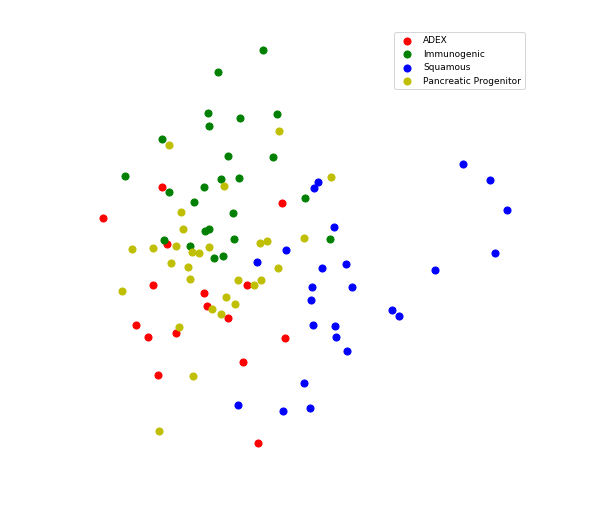

In [20]:
plt.figure()
plt.figure(figsize=(8,8))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20, c='w')
plt.ylabel('Principal Component - 2',fontsize=20, c='w')
plt.title("Principal Component Analysis of Pancreatic Cancer Dataset",fontsize=20, c='w')
plt.tick_params(axis='x', colors='w')
plt.tick_params(axis='y', colors='w')
targets = ['ADEX', 'Immunogenic', 'Squamous', 'Pancreatic Progenitor']
colors = ['r', 'g', 'b', 'y']
for target, color in zip(targets,colors):
    indicesToKeep = pca_df['subtype'] == target
    plt.scatter(pca_df.loc[indicesToKeep, 'pca_1']
               , pca_df.loc[indicesToKeep, 'pca_2'], c = color, s = 50)

plt.legend(targets,prop={'size': 9})
plt.show()

#### PCA considering batch-effect

In [21]:
# Preparing data for PCA
X_data = df_after_combat.to_numpy()

X_data = X_data.T

# Taking sample names from original dataframe
Y_data = list(expression_dataframe.columns)[2:]

In [22]:
# Making composition
pca_composition = sklearn.decomposition.PCA(n_components=2)
pca_X = pca_composition.fit_transform(X_data)

In [23]:
# We will make helpful dataframe
pca_df = pd.DataFrame(data = pca_X, columns=['pca_1', 'pca_2'])

pca_df.insert(0, 'subtype', pca_Y)

<Figure size 432x288 with 0 Axes>

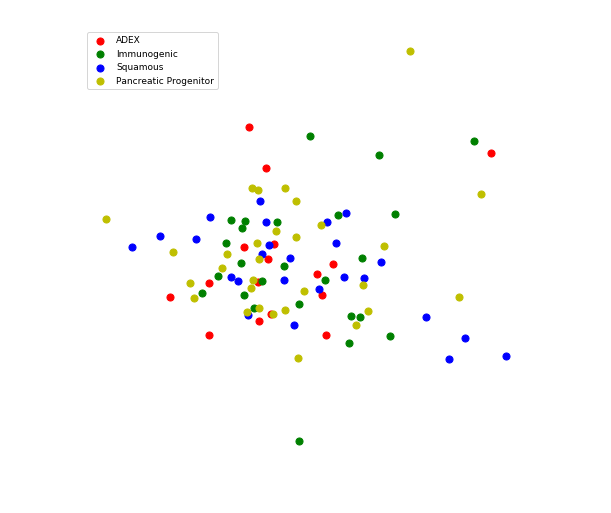

In [24]:
# plotting
plt.figure()
plt.figure(figsize=(8,8))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20, c='w')
plt.ylabel('Principal Component - 2',fontsize=20, c='w')
plt.title("Principal Component Analysis of Pancreatic Cancer Dataset",fontsize=20, c='w')
plt.tick_params(axis='x', colors='w')
plt.tick_params(axis='y', colors='w')
targets = ['ADEX', 'Immunogenic', 'Squamous', 'Pancreatic Progenitor']
colors = ['r', 'g', 'b', 'y']
for target, color in zip(targets,colors):
    indicesToKeep = pca_df['subtype'] == target
    plt.scatter(pca_df.loc[indicesToKeep, 'pca_1']
               , pca_df.loc[indicesToKeep, 'pca_2'], c = color, s = 50)

plt.legend(targets,prop={'size': 9})
plt.show()

* Сравнивая два графика для PCA (в особенности положение синих точек (Squamous подтип) относительно остальных), становится понятным, что ComBat достаточно сильно исправил наши данные. Таким образом в наших первоначальных данных скорее всего был batch-effect (однако утверждать это точно по результатам работы ComBat нельзя, требуются дополнительные анализы).
* В дальнейшем мы будем работать с исправленными данными

In [25]:
# saving df_after_combat in expression_dataframe
df_after_combat.columns = expression_dataframe.columns[2:]
df_after_combat.insert(0, 'gene_name', expression_dataframe.gene_name)
df_after_combat.insert(0, 'gene_id', expression_dataframe.gene_id)

expression_dataframe = df_after_combat
expression_dataframe.head()

,gene_id,gene_name,ICGC_0006,ICGC_0007,ICGC_0009,ICGC_0075,ICGC_0354,ICGC_0020,ICGC_0021,ICGC_0025,...,ICGC_0535,ICGC_0536,ICGC_0502,ICGC_0503,ICGC_0518,ICGC_0507,ICGC_0521,ICGC_0522,ICGC_0526,ICGC_0543
0,ENSG00000000003,TSPAN6,4.844671,5.084731,5.208572,4.282946,3.700065,4.695407,5.245084,5.455873,...,3.147953,4.120186,4.659151,4.858572,3.980307,4.123594,5.215544,4.132262,4.699730,4.971165
1,ENSG00000000419,DPM1,4.132214,4.552949,4.497532,3.565421,4.272474,4.350902,4.316119,4.694941,...,4.509866,4.358112,3.767564,4.400178,4.842628,3.960502,3.968082,3.310211,4.105770,5.126356
2,ENSG00000000457,SCYL3,3.829595,3.774202,3.886716,4.075227,3.678081,3.984816,3.749455,3.802835,...,3.918989,3.367255,4.064613,3.807436,3.939476,3.988303,4.781331,4.693744,4.161460,3.370083
3,ENSG00000000460,C1orf112,2.574038,2.599298,3.007375,2.883896,3.503547,2.557960,2.993491,3.790170,...,2.742554,2.870776,3.118026,2.236171,3.256904,2.803769,2.859149,3.329917,2.953560,3.243633
4,ENSG00000000938,FGR,2.865667,1.441619,2.647640,2.728091,1.772811,3.178097,3.219012,2.918867,...,3.366715,2.640649,1.715881,2.072422,2.403309,1.239831,1.348111,3.131777,2.629721,2.059646


#### Machine learning model just to try

In [26]:
# importing here just to show what we will take
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [27]:
# Preparing data for training
X_data = expression_dataframe.to_numpy()[:, 2:]

X_data = X_data.T

Y_data_class = [subtype_sample[sample] for sample in pca_Y]

In [28]:
# creating simple model
forest = RandomForestClassifier(n_estimators=500, max_depth = 15, max_features = 5000)

# splitting data
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data_class)

# learning
forest.fit(X_train, y_train)

print('Learning complete!')

Learning complete!


In [29]:
# printing results
print(classification_report(y_test, forest.predict(X_test)))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         9
           3       0.29      0.29      0.29         7
           4       0.07      0.20      0.11         5

    accuracy                           0.12        24
   macro avg       0.09      0.12      0.10        24
weighted avg       0.10      0.12      0.11        24



In [30]:
# interesting...

### Defining genes with abnormal expresison

In [31]:
# here we will use statsmodels package

from statsmodels.stats import multicomp

In [32]:
# making transposed dataframe
exp_T = expression_dataframe.transpose().reset_index()
exp_T = exp_T.rename(columns=exp_T.iloc[0])
exp_T = exp_T.drop(index=[0,1]).reset_index().drop(columns='index')

# returning subtype names for easier understanding
exp_T.insert(1, column='subtype', value=samples_subtype)

exp_T.head()

,gene_id,subtype,ENSG00000000003,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,...,ENSG00000269693,ENSG00000269728,ENSG00000269746,ENSG00000269793,ENSG00000269821,ENSG00000269825,ENSG00000269834,ENSG00000269837,ENSG00000269842,ENSG00000269858
0,ICGC_0006,ADEX,4.84467,4.13221,3.82959,2.57404,2.86567,7.44001,5.26639,5.26225,...,2.94639,4.33388,3.13202,-0.481228,8.62701,3.40212,-0.0859233,2.99237,0.269685,4.59173
1,ICGC_0007,Immunogenic,5.08473,4.55295,3.7742,2.5993,1.44162,7.58502,5.27979,4.96585,...,2.65077,4.05022,2.37474,-0.749976,7.54645,3.84089,0.422552,2.60306,0.0736706,4.74589
2,ICGC_0009,Squamous,5.20857,4.49753,3.88672,3.00738,2.64764,8.94026,5.58822,5.19567,...,3.57605,5.47948,1.6078,-2.21538,7.0702,2.4497,-0.509591,2.60923,-0.768951,4.71859
3,ICGC_0075,ADEX,4.28295,3.56542,4.07523,2.8839,2.72809,6.16892,5.90582,5.02911,...,4.08697,5.1231,2.55395,0.880015,9.14845,3.18467,-0.0890871,1.69889,1.83871,5.14891
4,ICGC_0354,ADEX,3.70007,4.27247,3.67808,3.50355,1.77281,6.22529,5.0121,4.86754,...,3.42894,3.02617,2.42418,0.274748,8.67394,4.96125,0.716451,1.94934,1.81387,4.91327


In [33]:
# taking samples for each subtype
sample_ad = exp_T.loc[exp_T.subtype == 'ADEX']
sample_sq = exp_T.loc[exp_T.subtype == 'Squamous']
sample_im = exp_T.loc[exp_T.subtype == 'Immunogenic']
sample_pp = exp_T.loc[exp_T.subtype == 'Pancreatic Progenitor']

In [34]:
# creating lists for genes which express differently in pair of subtypes
genes_ad_im = []
genes_ad_sq = []
genes_ad_pp = []
genes_im_sq = []
genes_im_pp = []
genes_sq_pp = []

# dict for finding where to append
where_append = {(1, 2): genes_ad_im, (1, 3): genes_ad_sq, (1, 4): genes_ad_pp, (2, 3): genes_im_sq, (2, 4): genes_im_pp, (3, 4): genes_sq_pp}

In [239]:
# lets find all genes which have different expression in different subtypes
# creating genes list
genes_list = exp_T.columns[2:]

for gene in genes_list:
    
    # calculating tukeyHSD stats
    stat_res = multicomp.pairwise_tukeyhsd(np.array(exp_T[gene], dtype='float64'), Y_data_class)
    
    # converting code
    table = stat_res.summary()
    results_as_html = table.as_html()
    df = pd.read_html(results_as_html)[0]

    # iterating for subtype pairs whose equality was rejected by test
    group_pairs = zip(df.loc[df.reject == True]['group1'], df.loc[df.reject == True]['group2'])
    
    for pair in group_pairs:
        where_append[pair].append(gene)

In [240]:
print(genes_ad_im)
print(genes_ad_sq)
print(genes_ad_pp)
print(genes_im_sq )
print(genes_im_pp)
print(genes_sq_pp)

['ENSG00000091704', 'ENSG00000103375', 'ENSG00000114204', 'ENSG00000124232', 'ENSG00000137392', 'ENSG00000138161', 'ENSG00000158516', 'ENSG00000162438', 'ENSG00000168925', 'ENSG00000170835', 'ENSG00000187021', 'ENSG00000204787', 'ENSG00000219073', 'ENSG00000240338']
['ENSG00000091704', 'ENSG00000138161', 'ENSG00000162438', 'ENSG00000219073']
['ENSG00000091704', 'ENSG00000103375', 'ENSG00000114204', 'ENSG00000124232', 'ENSG00000137392', 'ENSG00000138161', 'ENSG00000158516', 'ENSG00000162438', 'ENSG00000170835', 'ENSG00000187021', 'ENSG00000204787', 'ENSG00000219073']
[]
[]
[]


### Enrichment analysis

In [245]:
#TODO

### Analyzing patients

In [47]:
# reading patients table
patients_data = pd.read_csv('data/humans.csv', sep=';')

patients_data.head()

,icgc_id,Sample type,qpure_score,qpure >40%,KRAS BY WTS or WES,KRAS by Deep Amplicon,EXOME,WGS,SNP,RNASeq,...,Gender,Age at Diagnosis in Years,Country,Smoker,Tumour Grade,HistoSubtype,Tumour Location,AJCC Pathology Stage,Status,Length of Follow Up (months)
0,ICGC_0393,Primary tumour,52,YES,Y,Y,-,YES,YES,Bailey et al,...,Male,60,United States of America,Stopped Smoking,3 - Poorly differentiated,PDA - Adenosquamous carcinoma,Head,IB,Alive - Without Disease,"2,8"
1,ICGC_0354,Primary tumour,82,YES,Y,Y,-,YES,YES,YES,...,Male,49,Australia,Still Smoking,3 - Poorly differentiated,Pancreatic Ductal Adenocarcinoma,Head,IV,Deceased - Of Disease,"3,6"
2,ICGC_0392,Primary tumour,58,YES,Y,Y,-,YES,YES,Bailey et al,...,Male,50,United States of America,Not documented,3 - Poorly differentiated,Pancreatic Ductal Adenocarcinoma,Head,IIB,Deceased - Of Disease,"10,9"
3,ICGC_0391,Primary tumour,65,YES,N,N,-,YES,YES,Bailey et al,...,Male,64,Australia,Never Smoked,3 - Poorly differentiated,Acinar Cell Carcinoma,Head,IIB,Deceased - Of Disease,"15,8"
4,ICGC_0417,Primary tumour,54,YES,Y,Y,-,YES,YES,Bailey et al,...,Male,65,Australia,Never Smoked,2 - Moderately differentiated,Pancreatic Ductal Adenocarcinoma,Head,IIA,Alive - With Disease,"15,0"


In [48]:
# making subtypes column
col_subtype = [annotation_table.loc[annotation_table.icgc_id == sample].subtype.values[0] for sample in patients_data.icgc_id]

# inserting column
patients_data.insert(1, 'subtype', col_subtype)

patients_data.head()

,icgc_id,subtype,Sample type,qpure_score,qpure >40%,KRAS BY WTS or WES,KRAS by Deep Amplicon,EXOME,WGS,SNP,...,Gender,Age at Diagnosis in Years,Country,Smoker,Tumour Grade,HistoSubtype,Tumour Location,AJCC Pathology Stage,Status,Length of Follow Up (months)
0,ICGC_0393,Squamous,Primary tumour,52,YES,Y,Y,-,YES,YES,...,Male,60,United States of America,Stopped Smoking,3 - Poorly differentiated,PDA - Adenosquamous carcinoma,Head,IB,Alive - Without Disease,"2,8"
1,ICGC_0354,ADEX,Primary tumour,82,YES,Y,Y,-,YES,YES,...,Male,49,Australia,Still Smoking,3 - Poorly differentiated,Pancreatic Ductal Adenocarcinoma,Head,IV,Deceased - Of Disease,"3,6"
2,ICGC_0392,Squamous,Primary tumour,58,YES,Y,Y,-,YES,YES,...,Male,50,United States of America,Not documented,3 - Poorly differentiated,Pancreatic Ductal Adenocarcinoma,Head,IIB,Deceased - Of Disease,"10,9"
3,ICGC_0391,ADEX,Primary tumour,65,YES,N,N,-,YES,YES,...,Male,64,Australia,Never Smoked,3 - Poorly differentiated,Acinar Cell Carcinoma,Head,IIB,Deceased - Of Disease,"15,8"
4,ICGC_0417,Pancreatic Progenitor,Primary tumour,54,YES,Y,Y,-,YES,YES,...,Male,65,Australia,Never Smoked,2 - Moderately differentiated,Pancreatic Ductal Adenocarcinoma,Head,IIA,Alive - With Disease,"15,0"


#### Qpure_score

In [52]:
# tukey test
stat_res = multicomp.pairwise_tukeyhsd(np.array(patients_data.qpure_score, dtype='float64'),patients_data.subtype)
table = stat_res.summary()
table

group1,group2,meandiff,p-adj,lower,upper,reject
ADEX,Immunogenic,-6.1375,0.4736,-17.2246,4.9496,False
ADEX,Pancreatic Progenitor,-2.0042,0.9,-12.7246,8.7163,False
ADEX,Squamous,-5.4575,0.5645,-16.5446,5.6296,False
Immunogenic,Pancreatic Progenitor,4.1333,0.6396,-5.2446,13.5112,False
Immunogenic,Squamous,0.68,0.9,-9.1149,10.4749,False
Pancreatic Progenitor,Squamous,-3.4533,0.7452,-12.8312,5.9246,False


Тест Тьюки не показал значительных отклонений распределения Qpure_score (процент содержания раковых клеток в
образце биопсии) в разных подтипах рака. 
  
На всякий случай проверим это с помощью t-теста Стьюдента:

In [82]:
# lets go with harder way and check everything ourselves
# taking two subtypes
sam_ad = np.array(patients_data.loc[patients_data.subtype == 'ADEX'].qpure_score)
sam_sq = np.array(patients_data.loc[patients_data.subtype == 'Squamous'].qpure_score)

In [100]:
# checking normality of our samples
print('ADEX subtype Shapiro test:')
print(stats.shapiro(sam_ad))
print('Squamous subtype Shapiro test:')
print(stats.shapiro(sam_sq))

ADEX subtype Shapiro test:
(0.9531246423721313, 0.5407478213310242)
Squamous subtype Shapiro test:
(0.9648277759552002, 0.5186991095542908)


Таким образом, мы можем считать, что данные имеют нормальное распределение.

In [83]:
# checking equality of two variances
print(stats.bartlett(sam_ad, sam_sq))

BartlettResult(statistic=0.9356805532986253, pvalue=0.33339117411073665)


Тест Бартлетта показал, что мы не можем отвергнуть гипотезу о равенстве дисперсий в двух взятых выборках.  
Поэтому будем считать, что они равны.

In [86]:
# let's use Student's t-test
print(stats.ttest_ind(sam_ad, sam_sq, equal_var=True))

Ttest_indResult(statistic=1.2851824543621693, pvalue=0.20630864413228875)


P-value t-теста Стьюдента больше 0.2, поэтому мы не отвергаем гипотезу о том, что распределение Q_pure score НЕ различается в подтипах 'ADEX' и 'Squamous'  
  
Проделаем все те же действия со всеми возможными парами:

In [116]:
# taking rest subtypes
sam_im = np.array(patients_data.loc[patients_data.subtype == 'Immunogenic'].qpure_score)
sam_pp = np.array(patients_data.loc[patients_data.subtype == 'Pancreatic Progenitor'].qpure_score)

# preparing stuff for iterations
sub_lst = ['ADEX', 'Squamous', 'Immunogenic', 'Pancreatic Progenitor']
sub_it = it.combinations(sub_lst, 2)
cy_dict = {'ADEX': sam_ad, 'Squamous': sam_sq, 'Immunogenic': sam_im, 'Pancreatic Progenitor': sam_pp}

In [117]:
# checking normality of our data
for sub in sub_lst:
    print(f'{sub} subtype Shapiro test:')
    print(stats.shapiro(cy_dict[sub]))

ADEX subtype Shapiro test:
(0.9531246423721313, 0.5407478213310242)
Squamous subtype Shapiro test:
(0.9648277759552002, 0.5186991095542908)
Immunogenic subtype Shapiro test:
(0.961713969707489, 0.44965943694114685)
Pancreatic Progenitor subtype Shapiro test:
(0.9585792422294617, 0.2847941219806671)


In [118]:
# iterating and doing Student's t-test
for sub_a, sub_b in sub_it:
    sub_1 = cy_dict[sub_a]
    sub_2 = cy_dict[sub_b]

    bartlett = stats.bartlett(sub_1, sub_2)
    if bartlett[1] > 0.05:
        equal_var=True
    else:
        equal_var=False
    
    print(f'{sub_a} and {sub_b}: P-value = {stats.ttest_ind(sub_1, sub_2, equal_var=equal_var)[1]}')
    
# sorry for such big print

ADEX and Squamous: P-value = 0.20630864413228875
ADEX and Immunogenic: P-value = 0.15493628185363012
ADEX and Pancreatic Progenitor: P-value = 0.6571211368403069
Squamous and Immunogenic: P-value = 0.8416965569167572
Squamous and Pancreatic Progenitor: P-value = 0.3400801786852473
Immunogenic and Pancreatic Progenitor: P-value = 0.2531731422488433


In [148]:
# at last let's check anova

anova = stats.f_oneway(sam_ad, sam_im, sam_sq, sam_pp)
print(anova)

F_onewayResult(statistic=1.0102085165333352, pvalue=0.3919541377306284)


Таким образом, по полученным данным, мы не можем утверждать, что есть какие-либо статистически значимые отклонения в показатели Qpure_score для исследуемых подтипов рака (ни попарно, ни у всех вместе сразу).

#### Anlysis by Gender

* Для анализа по Gender будем считать, что в каждом из подтипов распределение 'Male' и 'Female' - это Биномиальное распределение, где, например, 'Female' - успех, а 'Male' - неудача :)

* Наша гипотеза для двух независимых выборок $H_0: p_1 = p_2$ (где $p_1$ и $p_2$ вероятности успеха для двух биномиальных распределений).    
* Используем следующую статистику критерия:
\begin{equation}z=\frac{\hat{p}_{1}-\hat{p}_{2}}{\sqrt{\hat{p}(1-\hat{p})\left(\frac{1}{n_{1}}+\frac{1}{n_{2}}\right)}}\end{equation}  
, где \begin{equation}\hat{p_i}=\frac{k_i}{n_i}\end{equation}  \begin{equation}\hat{p}=\frac{n_{1} \hat{p}_{1}+n_{2} \hat{p}_{2}}{n_{1}+n_{2}}\end{equation}
* Данная статистика будет иметь нормальное распределение.

In [129]:
# dict to convert gender into success-fail
dict_succ = {'Female': 1, 'Male': 0}
# taking data from out patients dataframe
samples_gender_ad = np.array([dict_succ[gender] for gender in patients_data.loc[patients_data.subtype == 'ADEX']['Gender']])
samples_gender_sq = np.array([dict_succ[gender] for gender in patients_data.loc[patients_data.subtype == 'Squamous']['Gender']])
samples_gender_im = np.array([dict_succ[gender] for gender in patients_data.loc[patients_data.subtype == 'Immunogenic']['Gender']])
samples_gender_pp = np.array([dict_succ[gender] for gender in patients_data.loc[patients_data.subtype == 'Pancreatic Progenitor']['Gender']])

In [133]:
def binom_analyze(a, b):
    """
    Function to analyze hypothesis for two groups from binominal dist
    """
    n_1 = len(a)
    n_2 = len(b)
    p_1 = sum(a)/n_1
    p_2 = sum(b)/n_2
    
    p = (n_1*p_1 + n_2*p_2)/(n_1 + n_2)
    
    z = (p_1 - p_2)/np.sqrt(p*(1-p)*(1/n_1 + 1/n_2))
    
    p_value = min(stats.norm.cdf(z), 1-stats.norm.cdf(z))
    
    return p_value

In [146]:
# preparing stuff for iterations
sub_lst = ['ADEX', 'Squamous', 'Immunogenic', 'Pancreatic Progenitor']
sub_it = it.combinations(sub_lst, 2)
cy_dict_gender = {'ADEX': samples_gender_ad, 'Squamous': samples_gender_sq, 'Immunogenic': samples_gender_im, 'Pancreatic Progenitor': samples_gender_pp}

for sub_a, sub_b in sub_it:
    sub_1 = cy_dict_gender[sub_a]
    sub_2 = cy_dict_gender[sub_b]
    
    print(f'P-value for {sub_a} and {sub_b}: {binom_analyze(sub_1, sub_2)}')

P-value for ADEX and Squamous: 0.4502712007885079
P-value for ADEX and Immunogenic: 0.45027120078850785
P-value for ADEX and Pancreatic Progenitor: 0.41466669551635604
P-value for Squamous and Immunogenic: 0.38864870539476065
P-value for Squamous and Pancreatic Progenitor: 0.46071999108484574
P-value for Immunogenic and Pancreatic Progenitor: 0.34680606328505337


In [149]:
# at last let's check anova

anova = stats.f_oneway(samples_gender_ad, samples_gender_sq, samples_gender_im, samples_gender_pp)
print(anova)

F_onewayResult(statistic=0.05496009651076467, pvalue=0.982938131897464)


#### Ethnicity

In [232]:
# lets take samples
all_samples = patients_data['Ethnicity']
samples_eth_ad = patients_data.loc[patients_data.subtype == 'ADEX']['Ethnicity']
samples_eth_sq = patients_data.loc[patients_data.subtype == 'Squamous']['Ethnicity']
samples_eth_im = patients_data.loc[patients_data.subtype == 'Immunogenic']['Ethnicity']
samples_eth_pp = patients_data.loc[patients_data.subtype == 'Pancreatic Progenitor']['Ethnicity']

* Так как анализы в большинстве своём проводились на белых людях ($86\%$ 'White/Caucasian' этнической принадлежности для всей выборки и для групп: $100\%$ - из 16 пациентов с 'ADEX', $88\%$ - из 25 пациентов с 'Squamous', $84\%$ - из 25 пациентов с 'Immunogenic', $80\% - из 30 пациентов с 'Pancreatic Progenitor'), то считаю, что проводить анализ "Cancer subtype from Ethnicity" нельзя из-за несбалансированости исследуемой выборки.

###  Age at Diagnosis in Years

In [165]:
# lets take samples
all_patients_years = list(patients_data['Age at Diagnosis in Years'])
samples_years_ad = patients_data.loc[patients_data.subtype == 'ADEX']['Age at Diagnosis in Years']
samples_years_sq = patients_data.loc[patients_data.subtype == 'Squamous']['Age at Diagnosis in Years']
samples_years_im = patients_data.loc[patients_data.subtype == 'Immunogenic']['Age at Diagnosis in Years']
samples_years_pp = patients_data.loc[patients_data.subtype == 'Pancreatic Progenitor']['Age at Diagnosis in Years']

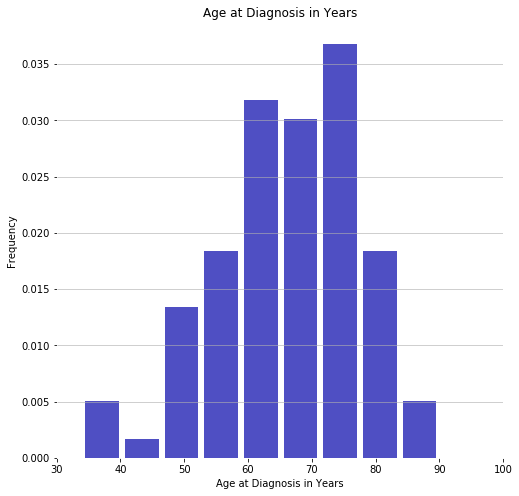

In [248]:
fig = plt.figure(figsize=(8,8))
prob_for_bins, bins, patches = plt.hist(x=all_patients_years, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85, density=True)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Age at Diagnosis in Years')
plt.ylabel('Frequency')
plt.title('Age at Diagnosis in Years')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim()
plt.xlim(30, 100)
plt.show()

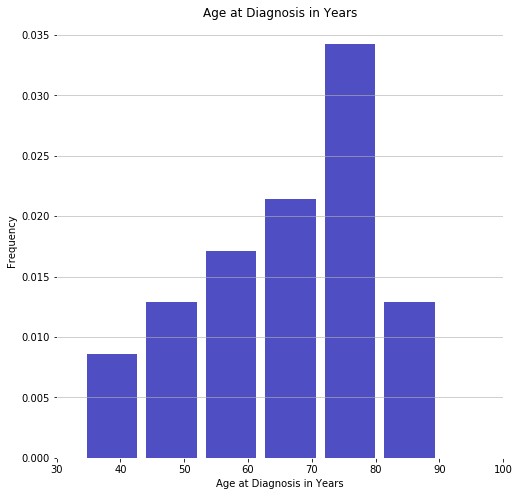

In [322]:
fig = plt.figure(figsize=(8,8))
prob_for_bins, bins, patches = plt.hist(x=samples_years_sq, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85, density=True)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Age at Diagnosis in Years')
plt.ylabel('Frequency')
plt.title('Age at Diagnosis in Years')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim()
plt.xlim(30, 100)
plt.show()

In [297]:
# let's check Shapiro test just for fun
stats.shapiro(samples_years_sq)

(0.9715133905410767, 0.6836257576942444)

Для проверки гипотезы о том

In [250]:
# taking bins and probabilities from histogram
bins = [40, 60, 70, 90]

bin_width = bins[1]-bins[0]

prob_for_bins = prob_for_bins

p_all = prob_for_bins*bin_width

In [265]:
def convert_years_list_to_prob(year_lst, bins):
    """
    Function to convert list with years to list with probabilities in bins.
    Probability for bin: p_bin = (numbert elements in bin)/(number of all elements).
    """
    # converting to np.array
    years_np = np.array(year_lst)
    
    # number of all elemnts
    n = len(years_np)
    
    # list to save where
    p_obs_lst = []
    
    # iterating by bins
    for i in range(len(bins)-1):
        # taking start and end for bin
        a, b = bins[i], bins[i+1]
        
        # calculating prob
        p_bin = len(years_np[(years_np >= a) & (years_np <= b)])/n
        
        # appending 
        p_obs_lst.append(p_bin+0.00000000001)
        
    return p_obs_lst

In [314]:
stats.ks_2samp(samples_years_pp, samples_years_sq)

Ks_2sampResult(statistic=0.17333333333333334, pvalue=0.7667663908520328)

In [293]:
stats.ttest_ind(samples_years_pp, samples_years_ad)

Ttest_indResult(statistic=0.8877204737919436, pvalue=0.37951818225648537)

In [ ]:
#TODO graph with 4 hists

### KRAS mutations

In [323]:
all_patients = patients_data['KRAS BY WTS or WES']

In [327]:
# dict to convert gender into success-fail
dict_success = {'Y': 1, 'N': 0}
# taking data from out patients dataframe
samples_kras_ad = np.array([dict_success[mut] for mut in patients_data.loc[patients_data.subtype == 'ADEX']['KRAS BY WTS or WES']])
samples_kras_sq = np.array([dict_success[mut] for mut in patients_data.loc[patients_data.subtype == 'Squamous']['KRAS BY WTS or WES']])
samples_kras_im = np.array([dict_success[mut] for mut in patients_data.loc[patients_data.subtype == 'Immunogenic']['KRAS BY WTS or WES']])
samples_kras_pp = np.array([dict_success[mut] for mut in patients_data.loc[patients_data.subtype == 'Pancreatic Progenitor']['KRAS BY WTS or WES']])


In [328]:
# preparing stuff for iterations
sub_lst = ['ADEX', 'Squamous', 'Immunogenic', 'Pancreatic Progenitor']
sub_it = it.combinations(sub_lst, 2)
cy_dict_kras = {'ADEX': samples_kras_ad, 'Squamous': samples_kras_sq, 'Immunogenic': samples_kras_im, 'Pancreatic Progenitor': samples_kras_pp}

for sub_a, sub_b in sub_it:
    sub_1 = cy_dict_kras[sub_a]
    sub_2 = cy_dict_kras[sub_b]
    
    print(f'P-value for {sub_a} and {sub_b}: {binom_analyze(sub_1, sub_2)}')

P-value for ADEX and Squamous: 0.004248344236503328
P-value for ADEX and Immunogenic: 0.2390526926463573
P-value for ADEX and Pancreatic Progenitor: 0.08866972000925571
P-value for Squamous and Immunogenic: 0.01852810928205939
P-value for Squamous and Pancreatic Progenitor: 0.05196322543587162
P-value for Immunogenic and Pancreatic Progenitor: 0.25308794944041213


In [332]:
# TODO проверить эксперссию для типов которые отличаются

### Выживаемость

In [360]:
patients_data.columns

Index(['icgc_id', 'subtype', 'Sample type', 'qpure_score', 'qpure >40%',
       'KRAS BY WTS or WES', 'KRAS by Deep Amplicon', 'EXOME', 'WGS', 'SNP',
       'RNASeq', 'HT-12 Expression array', '450K Methylation arrays',
       'SV analysis', 'Ethnicity', 'Gender', 'Age at Diagnosis in Years',
       'Country', 'Smoker', 'Tumour Grade', 'HistoSubtype', 'Tumour Location',
       'AJCC Pathology Stage', 'Status', 'Length of Follow Up (months)'],
      dtype='object')

In [374]:
# let's take part of our patient dataframe

surv_df = patients_data[['icgc_id', 'subtype', 'Status', 'Length of Follow Up (months)']]

In [375]:
# dict for changing status column
surv_dict = {'Deceased - Of Unknown Cause': -2, 'Deceased - Of Other Cause': -1, 'Deceased - Of Disease': 0, 'Alive - With Disease': 1, 'Alive - Without Disease': 2}

# converting status using dict
surv_df.insert(2, 'status', [surv_dict[sample] for sample in surv_df.Status])
surv_df = surv_df.drop(columns='Status')

# converting Length of Follow Up (months) to float type
surv_df.insert(3, 'length_time_month', [float(length.replace(',', '.')) for length in surv_df['Length of Follow Up (months)']])
surv_df = surv_df.drop(columns='Length of Follow Up (months)')

surv_df.head()

,icgc_id,subtype,status,length_time_month
0,ICGC_0393,Squamous,2,2.8
1,ICGC_0354,ADEX,0,3.6
2,ICGC_0392,Squamous,0,10.9
3,ICGC_0391,ADEX,0,15.8
4,ICGC_0417,Pancreatic Progenitor,1,15.0


In [406]:
surv_df.shape

(96, 4)

In [383]:
# small function

def status_convert(pd_ser):
    res = []
    for x in pd_ser:
        if x > 0:
            res.append(1)
        else:
            res.append(0)
    
    return np.array(res)

#### Kaplan-Meier curve

In [449]:
def construct_kmc(df, step):
    """
    Function to construct Kaplan-Meier curve
    """
    # probalility to survive
    surv_prob = [1]
    t_res = [t for t in range(0, 56, step)]
    
    n = df.shape[0]
    
    for t in t_res[1:]:
        #n = df.loc[(df.length_time_month > t) & (df.status <= 0)].shape[0]
        d = df.loc[(df.length_time_month < t) & (df.length_time_month >= (t-step)) & (df.status <= 0)].shape[0]   
        surv_prob.append(surv_prob[len(surv_prob)-1]*(n-d)/n)
        #print(t, n, d)
    
    return surv_prob, t_res

In [450]:
group_ad

,icgc_id,subtype,status,length_time_month
1,ICGC_0354,ADEX,0,3.6
3,ICGC_0391,ADEX,0,15.8
18,ICGC_0503,ADEX,2,27.5
29,ICGC_0048,ADEX,2,42.0
30,ICGC_0406,ADEX,2,14.0
35,ICGC_0338,ADEX,0,20.7
37,ICGC_0420,ADEX,0,6.5
52,ICGC_0201,ADEX,0,23.3
57,ICGC_0146,ADEX,2,35.0
67,ICGC_0205,ADEX,0,9.4


In [451]:
y, x = construct_kmc(group_ad, 3)

fig = plt.figure(figsize=(10,10))

kmf.fit(time_3, surv_3, label="Immunogenic").plot()
plt.step(x, y)

plt.show()

ZeroDivisionError: float division by zero

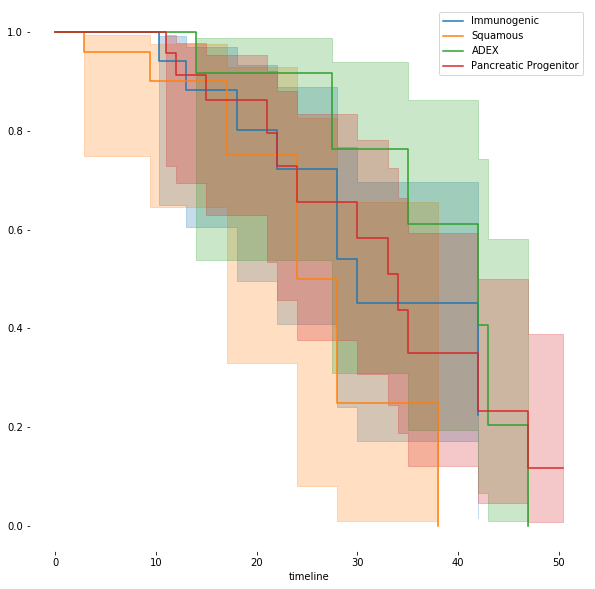

In [404]:
#KM curve
from lifelines import KaplanMeierFitter

# taking data
group_im = surv_df.loc[surv_df.subtype == 'Immunogenic']
group_pp = surv_df.loc[surv_df.subtype == 'Pancreatic Progenitor']
group_ad = surv_df.loc[surv_df.subtype == 'ADEX']
group_sq = surv_df.loc[surv_df.subtype == 'Squamous']

time_1 = np.array(group_im['length_time_month'])
surv_1 = status_convert(group_im['status'])
time_2 = np.array(group_sq['length_time_month'])
surv_2 = status_convert(group_sq['status'])
time_3 = np.array(group_ad['length_time_month'])
surv_3 = status_convert(group_ad['status'])
time_4 = np.array(group_pp['length_time_month'])
surv_4 = status_convert(group_pp['status'])

# plotting KM
kmf = KaplanMeierFitter()

fig = plt.figure(figsize=(10,10))

kmf.fit(time_1, surv_1, label="Immunogenic").plot()
kmf.fit(time_2, surv_2, label="Squamous").plot()
kmf.fit(time_3, surv_3, label="ADEX").plot()
kmf.fit(time_4, surv_4, label="Pancreatic Progenitor").plot()

plt.show()

In [403]:
surv_2

array([1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0])

In [402]:
#logrank_test
from lifelines.statistics import logrank_test
results=logrank_test(time_3 , time_4 ,event_observed_A=surv_3, event_observed_B=surv_4)
results.print_summary()